# Load data of shape (N, 8), (N, 12)

In [1]:
from Library import load_datasets
from Library import eth_data_manager
from Library import loss_multi_output

In [2]:
# Load dataset
trajs,trajs_hotel = load_datasets()

X is 8 pos and y is 12 pos

In [3]:
# Get different data
train_range = range(8)
#train_range_vel = range(10,12)
pred_pos = 20
X_no_vel, y_no_vel = eth_data_manager(trajs,train_range,pred_pos,multi_output=True)
X, y = eth_data_manager(trajs,train_range,pred_pos,multi_output=True,train_vel=True)

In [4]:
print(X_no_vel.shape, y_no_vel.shape)
print(X.shape, y.shape)

(271, 16) (271, 24)
(271, 32) (271, 24)


In [5]:
print(X[0])
print(y[0])

[13.017548   12.08777    11.746306   11.175158   10.43429    10.050254
  9.5712958   9.0840742   5.57932656  7.63842524  9.00846856  7.8951162
  8.18448328  8.75576324  8.6051158   8.57480176  5.7825914   5.751949
  5.7298146   5.8362471   5.8732028   6.1714868   6.2373547   6.2638361
  5.5374524   5.56723005  5.98270874  6.19471766  6.54368224  6.71771463
  6.329704    6.33217241]
[8.5527509 8.0978874 7.6353672 7.1670909 6.7341728 6.3426199 5.9914678
 5.5973695 5.2394674 5.0151027 4.7975924 4.5440437 6.3740273 6.4810373
 6.5483408 6.616482  6.6414608 6.7058853 6.7683596 6.9181861 6.9822277
 7.0384316 7.2222416 7.5798647]


# Evaluate multioutput models

In [6]:
from sklearn.model_selection import cross_val_score
from numpy import mean
from numpy import std

In [7]:
import numpy as np
np.random.seed(123)
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
            X_no_vel, y_no_vel, test_size=0.25, random_state=42)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42)

In [76]:
X_train.shape

(203, 32)

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge

In [33]:
linreg = LinearRegression()
knnreg = KNeighborsRegressor()
dtreg = DecisionTreeRegressor()
rfreg = RandomForestRegressor()
ridge = Ridge()

estimators = [linreg,knnreg,dtreg,rfreg,ridge]

In [65]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [62]:
def custom_ADE_loss(y_test, y_hut):
    y_test_x_coor = y_test[:, :12]
    y_test_y_coor = y_test[:, 12:]

    y_hut_x_coor = y_hut[:, :12]
    y_hut_y_coor = y_hut[:, 12:]

    result_vector = ((((y_test_x_coor - y_hut_x_coor)**2) +
                     ((y_test_y_coor - y_hut_y_coor)**2))**0.5)
    #print("ADE ", np.average(result_vector))
    #print("FDE ", np.average(result_vector[:, -1]))
    return np.average(result_vector)

In [63]:
def custom_FDE_loss(y_test, y_hut):
    y_test_x_coor = y_test[:, :12]
    y_test_y_coor = y_test[:, 12:]

    y_hut_x_coor = y_hut[:, :12]
    y_hut_y_coor = y_hut[:, 12:]

    result_vector = ((((y_test_x_coor - y_hut_x_coor)**2) +
                     ((y_test_y_coor - y_hut_y_coor)**2))**0.5)
    #print("ADE ", np.average(result_vector))
    #print("FDE ", np.average(result_vector[:, -1]))
    return np.average(result_vector[:, -1])

In [74]:
ADE_score = make_scorer(custom_ADE_loss, greater_is_better=False)
FDE_score = make_scorer(custom_FDE_loss, greater_is_better=False)

for estimator in estimators:
    print(str(estimator))
    scores = abs(cross_val_score(estimator, X_train, y_train, scoring=ADE_score))
    #print(scores)
    print('Mean ADE: %.4f' % (np.mean(scores)))

LinearRegression()
Mean ADE: 2756.2967
KNeighborsRegressor()
Mean ADE: 0.7998
DecisionTreeRegressor()
Mean ADE: 1.2847
RandomForestRegressor()
Mean ADE: 0.7372
Ridge()
Mean ADE: 0.4217


In [75]:
for estimator in estimators:
    print(str(estimator))
    scores = abs(cross_val_score(estimator, X_train, y_train, scoring=FDE_score))
    #print(scores)
    print('Mean FDE: %.4f' % (np.mean(scores)))

LinearRegression()
Mean FDE: 6064.8471
KNeighborsRegressor()
Mean FDE: 1.0799
DecisionTreeRegressor()
Mean FDE: 1.5296
RandomForestRegressor()
Mean FDE: 0.9743
Ridge()
Mean FDE: 0.8341


In [38]:
for estimator in estimators:
    print(str(estimator))
    loss_multi_output(estimator, X_train, y_train, X_test, y_test)

LinearRegression()
ADE  0.43355481730602685
FDE  0.8921229039756506
KNeighborsRegressor()
ADE  0.7242698006227922
FDE  0.9683687368839787
DecisionTreeRegressor()
ADE  1.023870526105182
FDE  1.1774980788824354
RandomForestRegressor()
ADE  0.7561720684454323
FDE  0.9263283902969615
Ridge()
ADE  0.3790445301747883
FDE  0.7645348982785434


In [11]:
scores_all = {}
for estimator in estimators:
    scores = abs(cross_val_score(estimator, X, y, scoring="neg_mean_squared_error"))
    scores_all[str(estimator)] = scores
    print("MSE for", str(estimator))
    print('  %.4f (%.4f)' % (mean(scores), std(scores)))

MSE for LinearRegression()
  0.1842 (0.0313)
MSE for KNeighborsRegressor()
  0.5677 (0.1627)
MSE for DecisionTreeRegressor()
  1.2327 (0.3556)
MSE for RandomForestRegressor()
  0.5032 (0.1462)
MSE for Ridge()
  0.1541 (0.0348)


In [12]:
loss_multi_output(estimators[4],X_train,y_train,X_test,y_test)
loss_multi_output(estimators[0],X_train,y_train,X_test,y_test)

ADE  0.37697409351812056
FDE  0.7674193511288053
ADE  0.43361808991239703
FDE  0.8909782951042959


{'whiskers': [<matplotlib.lines.Line2D at 0x195388bdee0>,
 'caps': [<matplotlib.lines.Line2D at 0x195388bddf0>,
 'boxes': [<matplotlib.lines.Line2D at 0x19538b0bc70>,
 'medians': [<matplotlib.lines.Line2D at 0x19538a74700>,
 'fliers': [<matplotlib.lines.Line2D at 0x19538a74b80>,
 'means': []}

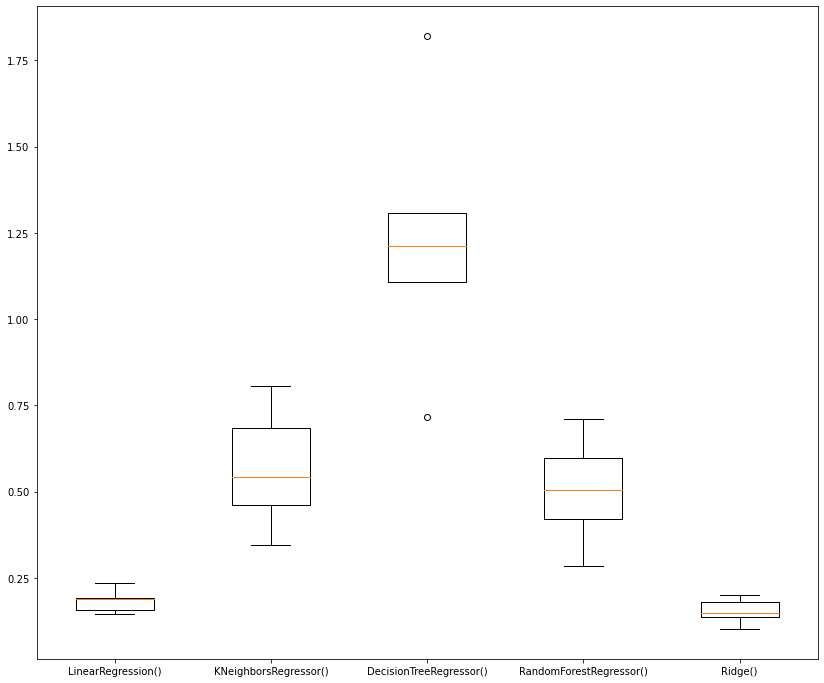

In [13]:
plt.figure(figsize=(14,12))
plt.boxplot(scores_all.values(), labels=scores_all.keys())

In [14]:
scores_best = {}
scores_best[list(scores_all.keys())[0]] = scores_all[list(scores_all.keys())[0]]
scores_best[list(scores_all.keys())[4]] = scores_all[list(scores_all.keys())[4]]

{'whiskers': [<matplotlib.lines.Line2D at 0x195389dfac0>,
 'caps': [<matplotlib.lines.Line2D at 0x195389dfd00>,
 'boxes': [<matplotlib.lines.Line2D at 0x195389df880>,
 'medians': [<matplotlib.lines.Line2D at 0x19538b1c7f0>,
 'fliers': [<matplotlib.lines.Line2D at 0x19538b1cc70>,
 'means': []}

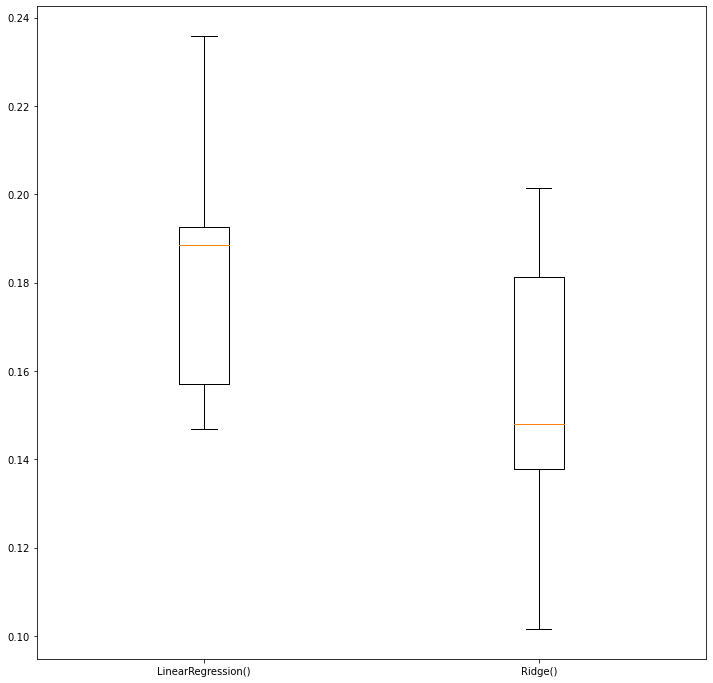

In [15]:
plt.figure(figsize=(12,12))
plt.boxplot(scores_best.values(), labels=scores_best.keys())

In [16]:
from sklearn.metrics import mean_squared_error

ADE = Average Displacement Error, error for trajectory prediction, averaging over MSE's of predicted points;

FDE = Final Displacement Error, error for prediction of the final point in the trajectory, basically MSE

MSE (ADE and FDE) for Ridge is the lowest

In [17]:
mean_squared_error(y_test, estimators[4].fit(X_train, y_train).predict(X_test))

0.14494594846622033

In [18]:
mean_squared_error(y_test[:,-1], estimators[4].fit(X_train, y_train).predict(X_test)[:,-1])

0.46859241683774977

MSE (ADE and FDE) for LR is second lowest

In [19]:
mean_squared_error(y_test, estimators[0].fit(X_train, y_train).predict(X_test))

0.20178219352512586

In [20]:
mean_squared_error(y_test[:,-1], estimators[0].fit(X_train, y_train).predict(X_test)[:,-1])

0.5622805208713464

# GridSearchCV on Ridge

In [10]:
from sklearn.model_selection import GridSearchCV

In [22]:
ridge = Ridge()

gs = GridSearchCV(ridge, 
    {'alpha':[0.01,0.1,0.5,1.0,2.0,4.0,8.0,16.0,32.0,64.0],'tol': [1e-5,1e-4,1e-3,1e-2,1e-1]},
    scoring='neg_root_mean_squared_error')

In [23]:
loss_multi_output(gs, X_train, y_train, X_test, y_test)

ADE  0.3807265384389506
FDE  0.7430230214829329


In [24]:
gs.best_params_

{'alpha': 32.0, 'tol': 1e-05}

# Evaluate SVR as multioutput and chained

In [21]:
from sklearn.svm import LinearSVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.multioutput import RegressorChain

In [22]:
svr = LinearSVR(max_iter=5000, epsilon=0.1)
moreg = MultiOutputRegressor(svr)

chained = RegressorChain(svr, order=None)

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# scaling helps the moreg but not the chained with converging, worse res with scaling
svr = LinearSVR(max_iter=5000)
moreg = Pipeline([('scaler', MinMaxScaler()),('reg', MultiOutputRegressor(svr))])

chained = Pipeline([('scaler', MinMaxScaler()),('reg', RegressorChain(svr, order=None))])

In [24]:
for estimator in [moreg, chained]:
    scores = cross_val_score(estimator, X, y, scoring="neg_mean_squared_error", )
    print("MSE for", str(estimator))
    print('  %.4f (%.4f)' % (mean(abs(scores)), std(abs(scores))))

C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed

MSE for Pipeline(steps=[('scaler', MinMaxScaler()),
                ('reg',
                 MultiOutputRegressor(estimator=LinearSVR(max_iter=5000)))])
  0.1638 (0.0409)


C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed

C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed

C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed

MSE for Pipeline(steps=[('scaler', MinMaxScaler()),
                ('reg',
                 RegressorChain(base_estimator=LinearSVR(max_iter=5000)))])
  0.1683 (0.0479)


C:\xampp\anaconda\lib\site-packages\sklearn\svm\_base.py:974: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
